In [ ]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
from control import lqr
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos
from scipy import integrate
from scipy.integrate import solve_ivp
import sympy as sp
from sympy.utilities.lambdify import lambdify

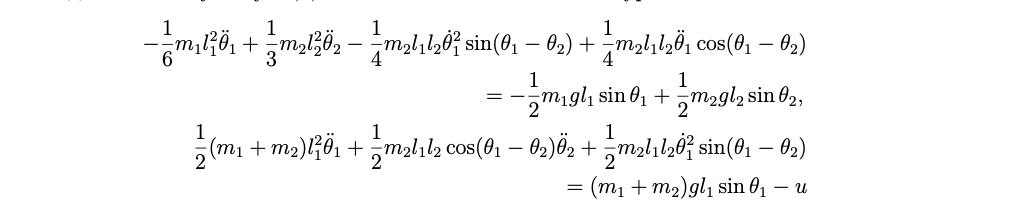

In [ ]:
theta1, theta2 = sp.symbols('theta1 theta2', real=True)
theta1_dot, theta2_dot = sp.symbols('theta1_dot theta2_dot', real=True)
theta1_ddot, theta2_ddot = sp.symbols('theta1_ddot theta2_ddot', real=True)
m1, m2, l1, l2, g, u = sp.symbols('m1 m2 l1 l2 g u', real=True, positive=True)

#исходные уравнения
eq1 = (-1/6)*m1*l1**2*theta1_ddot + (1/3)*m2*l2**2*theta2_ddot \
      - (1/4)*m2*l1*l2*theta1_dot*sp.sin(theta1-theta2) \
      + (1/4)*m2*l1*l2*theta1_ddot*sp.cos(theta1-theta2) \
      + (1/2)*m1*g*l1*sp.sin(theta1) - (1/2)*m2*g*l2*sp.sin(theta2)

eq2 = (1/2)*(m1 + m2)*l1**2*theta1_ddot \
      + (1/2)*m2*l1*l2*sp.cos(theta1 - theta2)*theta2_ddot \
      + (1/2)*m2*l1*l2*theta1_dot**2*sp.sin(theta1 - theta2) \
      - (m1 + m2)*g*l1*sp.sin(theta1) + u

solutions = sp.solve([eq1, eq2], (theta1_ddot, theta2_ddot))

In [ ]:
theta1_ddot_expr = solutions[theta1_ddot]
theta2_ddot_expr = solutions[theta2_ddot]

print("theta1'' =", sp.simplify(theta1_ddot_expr))
print("theta2'' =", sp.simplify(theta2_ddot_expr))

theta1'' = (3.0*g*l1**2*m1*sin(theta2) + 3.0*g*l1**2*m1*sin(2*theta1 - theta2) + 8.0*g*l1*l2*m1*sin(theta1) + 5.0*g*l1*l2*m2*sin(theta1) + 3.0*g*l1*l2*m2*sin(theta1 - 2*theta2) - 1.5*l1**2*l2*m2*theta1_dot*sin(2*theta1 - 2*theta2) - 4.0*l1*l2**2*m2*theta1_dot**2*sin(theta1 - theta2) - 8.0*l2*u)/(l1**2*(2.0*l1*m1*cos(theta1 - theta2) + 4.0*l2*m1 - 3.0*l2*m2*cos(theta1 - theta2)**2 + 4.0*l2*m2))
theta2'' = (-2.0*g*l1**2*m1**2*sin(theta1) - 2.0*g*l1**2*m1*m2*sin(theta1) + 3.0*g*l1*l2*m1*m2*sin(theta2) - 3.0*g*l1*l2*m1*m2*sin(2*theta1 - theta2) + 3.0*g*l1*l2*m2**2*sin(theta2) - 3.0*g*l1*l2*m2**2*sin(2*theta1 - theta2) - 2.0*l1**2*l2*m1*m2*theta1_dot**2*sin(theta1 - theta2) + 3.0*l1**2*l2*m1*m2*theta1_dot*sin(theta1 - theta2) + 3.0*l1**2*l2*m2**2*theta1_dot*sin(theta1 - theta2) + 1.5*l1*l2**2*m2**2*theta1_dot**2*sin(2*theta1 - 2*theta2) - 4.0*l1*m1*u + 6.0*l2*m2*u*cos(theta1 - theta2))/(l1*l2*m2*(2.0*l1*m1*cos(theta1 - theta2) + 4.0*l2*m1 - 3.0*l2*m2*cos(theta1 - theta2)**2 + 4.0*l2*m2))


$x = [\theta_1, \theta_2, \dot\theta_1, \dot\theta_2]^T$

$\dot x = [x_3, x_4, \dot x_3, \dot x_4]^T$

Тогда можно записать систему в виде $\dot x = f(x, u)$, которую далее можно линеаризовать.

Из условия в положении равновесия получаем $u = 0$.

In [ ]:
# равновесие
point = {theta1: 0, theta2: 0, theta1_dot: 0, theta2_dot: 0, u: 0}

# Вектор состояния
x = sp.Matrix([theta1, theta2, theta1_dot, theta2_dot])
f = sp.Matrix([
    theta1_dot,
    theta2_dot,
    theta1_ddot_expr,
    theta2_ddot_expr
])

# Матрицы A и B
A_sym = f.jacobian(x)
B_sym = f.jacobian(sp.Matrix([u]))
A_lin = A_sym.subs(point)
B_lin = B_sym.subs(point)

In [ ]:
sp.simplify(A_lin)

Matrix([
[                                                                                                         0,                                                     0, 1, 0],
[                                                                                                         0,                                                     0, 0, 1],
[                            g*(6.0*l1*m1 + 8.0*l2*m1 + 8.0*l2*m2)/(l1*(2.0*l1*m1 + 4.0*l2*m1 + 1.0*l2*m2)), -6.0*g*l2*m2/(l1*(2.0*l1*m1 + 4.0*l2*m1 + 1.0*l2*m2)), 0, 0],
[g*(-2.0*l1*m1**2 - 2.0*l1*m1*m2 - 6.0*l2*m1*m2 - 6.0*l2*m2**2)/(l2*m2*(2.0*l1*m1 + 4.0*l2*m1 + 1.0*l2*m2)),   6.0*g*(m1 + m2)/(2.0*l1*m1 + 4.0*l2*m1 + 1.0*l2*m2), 0, 0]])

In [ ]:
sp.simplify(B_lin)

Matrix([
[                                                                      0],
[                                                                      0],
[                    -8.0*l2/(l1**2*(2.0*l1*m1 + 4.0*l2*m1 + 1.0*l2*m2))],
[(-4.0*l1*m1 + 6.0*l2*m2)/(l1*l2*m2*(2.0*l1*m1 + 4.0*l2*m1 + 1.0*l2*m2))]])

In [ ]:
# параметры из условия
m1 = 1.0
m2 = 0.5
l1 = 0.5
l2 = 1.0
g = 9.81

In [ ]:
# матрицы системы
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [(g*(6*l1*m1+8*l2*m1+8*l2*m2))/(l1*(2*l1*m1+4*l2*m1+l2*m2)), (-6*g*l2*m2)/(l1*(2*l1*m1+4*l2*m1+l2*m2)), 0, 0],
    [(g*(-2*l1*m1**2-2*l1*m1*m2-6*l2*m1*m2-6*l2*m2**2))/(l2*m2*(2*l1*m1+4*l2*m1*l2*m2)), (6*g*(m1+m2))/(2*l1*m1+4*l2*m1*l2*m2), 0, 0]
])

B = np.array([
    [0],
    [0],
    [(-8*l2)/(l1**2*(2*l1*m1*4*l2*m1+l2*m2))],
    [(-4*l1*m1+6*l2*m2)/(l1*l2*m2*(2*l1*m1+4*l2*m1+l2*m2))]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])


Q = np.diag([1, 1, 1, 1])

# параметры для чм
tf = 5
t_eval = np.linspace(0.0, tf, 1000)
x0 = np.array([0.1, 0.2, 0.3, 0.4])

In [ ]:
A, B, C

(array([[  0.        ,   0.        ,   1.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ],
        [ 53.50909091, -10.70181818,   0.        ,   0.        ],
        [-39.24      ,  29.43      ,   0.        ,   0.        ]]),
 array([[ 0.        ],
        [ 0.        ],
        [-7.11111111],
        [ 0.72727273]]),
 array([[1, 0, 0, 0],
        [0, 0, 1, 0]]))

# y = x

In [ ]:
# проверим управляемость
rg = np.linalg.matrix_rank(np.hstack((
    B, np.dot(A, B),
    np.dot(np.linalg.matrix_power(A, 2), B),
    np.dot(np.linalg.matrix_power(A, 3), B)
)))
if rg == 4 :
  print("Система управляема")
else :
  print("Система не является управляемой")

Система управляема


In [ ]:
# LQR
R = np.diag([1])
K = lqr(A, B, Q, R)[0]

In [ ]:
A, B, K

(array([[  0.        ,   0.        ,   1.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ],
        [ 53.50909091, -10.70181818,   0.        ,   0.        ],
        [-39.24      ,  29.43      ,   0.        ,   0.        ]]),
 array([[ 0.        ],
        [ 0.        ],
        [-7.11111111],
        [ 0.72727273]]),
 array([[-42.15324968,  35.54631796,  -3.06565796,   6.46382372]]))

In [ ]:
# решаем x' = (A-BK)x
def f(t, x):
  return np.dot((A - np.dot(B, K)), x)

sol = solve_ivp(f, t_span=(0,tf), t_eval=t_eval, y0=x0)
t = sol.t
x = sol.y.T


In [ ]:
u = -np.dot(K, x.T).T

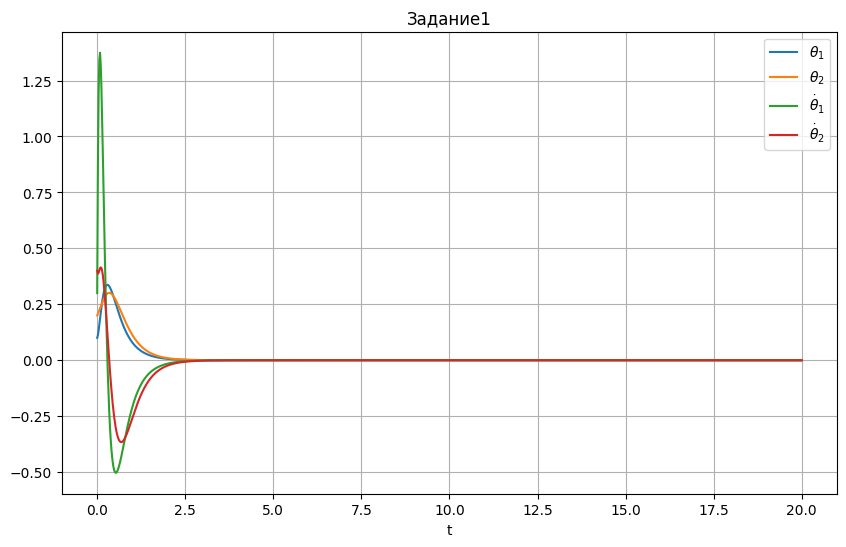

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, x[:, 0], label=r'$\theta_1$')
plt.plot(t, x[:, 1], label=r'$\theta_2$')
plt.plot(t, x[:, 2], label=r'$\dot\theta_1$')
plt.plot(t, x[:, 3], label=r'$\dot\theta_2$')
plt.xlabel('t')
plt.title('Задание1')
plt.legend()
plt.grid()
plt.show()

# y = Cx

In [ ]:
# проверяем на наблюдаемость
rg = np.linalg.matrix_rank(np.vstack((
    C, np.dot(C, A),
    np.dot(C, np.linalg.matrix_power(A, 2)),
    np.dot(C, np.linalg.matrix_power(A, 3))
)))
if rg == 4 :
  print("Система управляема")
else :
  print("Система не является управляемой")

Система управляема


In [ ]:
# LQR
R = np.diag([1, 1])
L = (lqr(A.T, C.T, Q, R)[0]).T

In [ ]:
def extended_f(t, x_ext):
  x = x_ext[:4]
  x_hat = x_ext[4:8]
  y = np.dot(C, x)
  y_hat = np.dot(C, x_hat)
  dxdt = np.dot(A,x) - np.dot(np.dot(B, K), x_hat)
  dxdt_hat = np.dot((A - np.dot(B, K)), x_hat) + np.dot(L, (y - y_hat))
  return np.hstack((dxdt, dxdt_hat))

x0_hat = np.array([1, 1, -10, 1])
x_ext_0 = np.hstack((x0, x0_hat))
sol_ext = solve_ivp(extended_f, t_span=(0, tf), y0=x_ext_0, t_eval=t_eval)
t_ext = sol_ext.t
x_ext = sol_ext.y.T

In [ ]:
# Находим оптимальное управление u = -K(x_hat)
u_ext = -np.dot(K, (x_ext[:, 4:8]).T).T

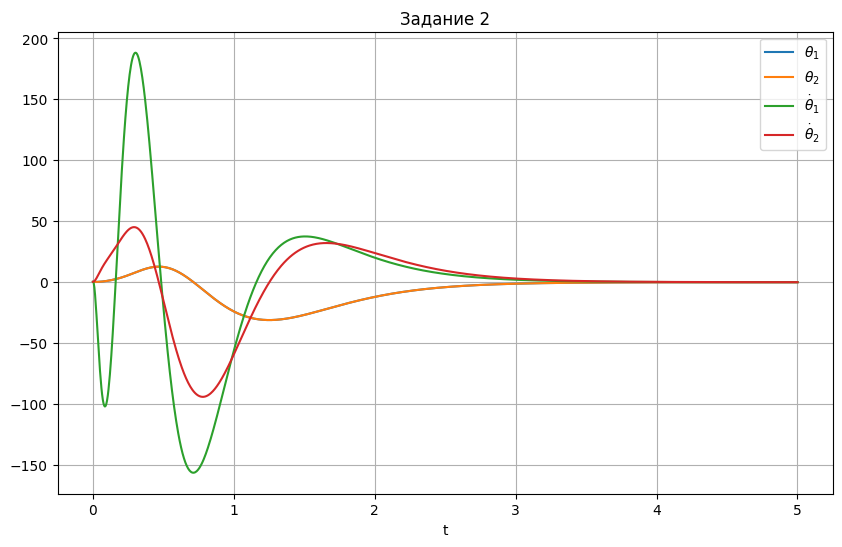

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_ext, x_ext[:, 1], label=r'$\theta_1$')
plt.plot(t_ext, x_ext[:, 1], label=r'$\theta_2$')
plt.plot(t_ext, x_ext[:, 2], label=r'$\dot\theta_1$')
plt.plot(t_ext, x_ext[:, 3], label=r'$\dot\theta_2$')
plt.xlabel('t')
plt.title('Задание 2')
plt.legend()
plt.grid()
plt.show()

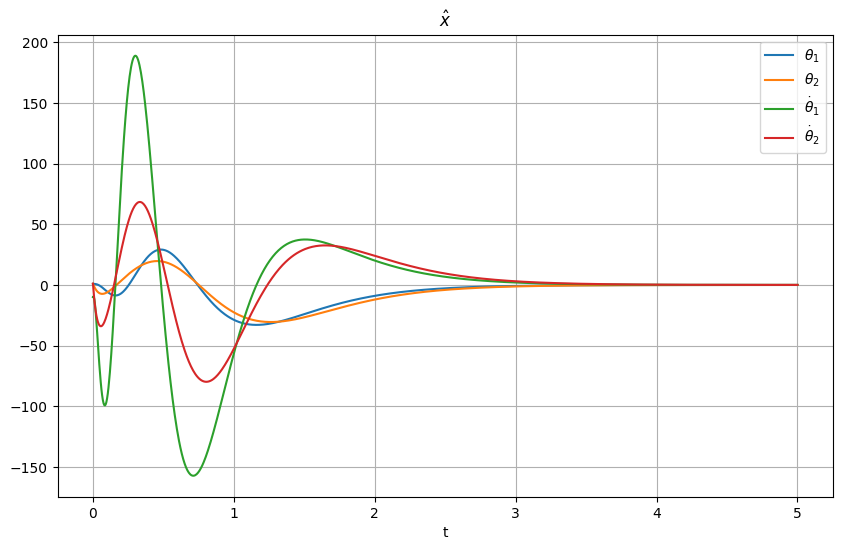

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_ext, x_ext[:, 4], label=r'$\theta_1$')
plt.plot(t_ext, x_ext[:, 5], label=r'$\theta_2$')
plt.plot(t_ext, x_ext[:, 6], label=r'$\dot\theta_1$')
plt.plot(t_ext, x_ext[:, 7], label=r'$\dot\theta_2$')
plt.xlabel('t')
plt.title('$\hat x$')
plt.legend()
plt.grid()
plt.show()

# Фильтр Калмана

In [ ]:
# матрицы ковариации возмущения и шума
Vn = np.diag([0.1*val for val in x0[:2]])
Vn = (abs(Vn + Vn.T) / 2) * 0.1

Vd = np.diag([0.1*val for val in x0])
Vd = (abs(Vd + Vd.T) / 2) * 0.1

# генерация помех
N = len(t_eval)
wd_all = np.random.multivariate_normal(np.zeros(4), Vd, size=len(t_eval))
wn_all = np.random.multivariate_normal(np.zeros(2), Vn, size=len(t_eval))

Управляемость была проверена в предыдущем пункте.

In [ ]:
# LQR
L = (lqr(A.T, C.T, Vd, Vn)[0]).T

In [ ]:
# решаем x' = (A-BK)x + BKe + wd, e' = (A-LC)e - Lwn + wd
def extended_system(t, x_ext):
    x = x_ext[:4]
    e = x_ext[4:8]
    i = np.argmin(np.abs(t - t_eval))
    wd = wd_all[i]
    wn = wn_all[i]
    dxdt = np.dot((A - np.dot(B, K)), x) + np.dot(np.dot(B, K), e) + wd
    dedt = np.dot((A - np.dot(L, C)), e) - np.dot(L, wn) + wd
    return np.hstack((dxdt, dedt))

x_ext_0 = np.hstack((x0, x0))
sol_ext = solve_ivp(extended_system, t_span=(0, tf), y0=x_ext_0, t_eval=t_eval)
t_ext = sol_ext.t
x_ext = sol_ext.y.T

In [ ]:
# Находим оптимальное управление u = -K(x - e)
u_ext = -np.dot(K, (x_ext[:, :4] - x_ext[:, 4:8]).T).T

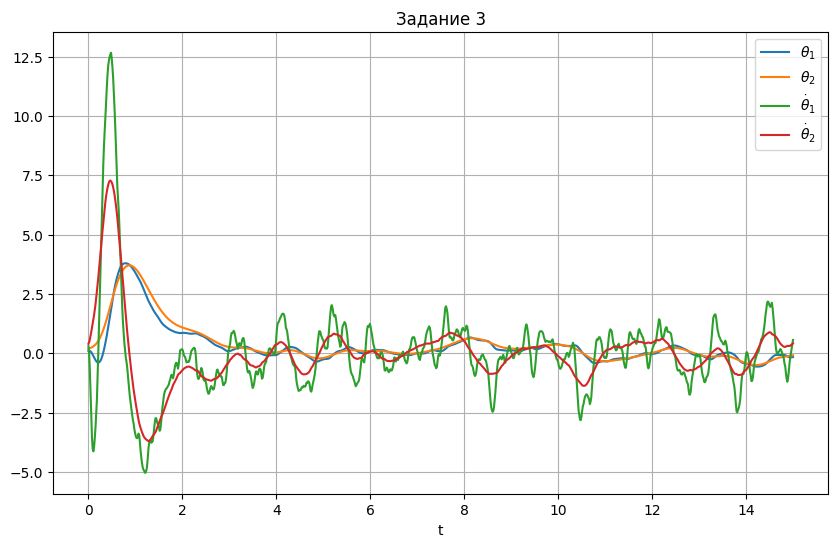

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_ext, x_ext[:, 0], label=r'$\theta_1$')
plt.plot(t_ext, x_ext[:, 1], label=r'$\theta_2$')
plt.plot(t_ext, x_ext[:, 2], label=r'$\dot\theta_1$')
plt.plot(t_ext, x_ext[:, 3], label=r'$\dot\theta_2$')
plt.xlabel('t')
plt.title('Задание 3')
plt.legend()
plt.grid()
plt.show()